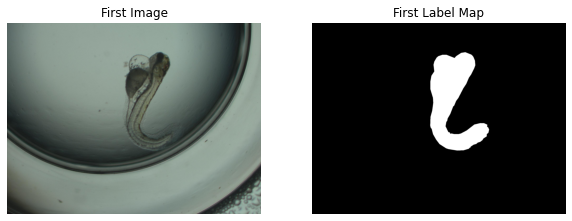

In [ ]:
import os
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def create_data_from_folder(folder_path):
    """
    Create lists of image and label arrays (binary masks) from a given folder.
    
    Args:
        folder_path (str): Path to the folder containing images and .xml files.
    
    Returns:
        tuple: Two lists, one for images (as numpy arrays) and one for labels (as numpy arrays).
    """
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg'))]
    xml_files = []

    # Find corresponding XML files based on image filenames
    for image_file in image_files:
        # Get the base name of the image file (remove the ".jpg" part)
        base_name = image_file.replace('.jpg', '')

        # Find the corresponding XML file by using the base name
        xml_file = [f for f in os.listdir(folder_path) if base_name in f and f.endswith('.xml')]

        # If a corresponding XML file is found, add to xml_files list
        if xml_file:
            xml_files.append(xml_file[0])  # Assume there is only one corresponding XML file

    images = []
    labels = []

    # Process each image and its corresponding XML
    for image_file, xml_file in zip(image_files, xml_files):
        img_path = os.path.join(folder_path, image_file)
        xml_path = os.path.join(folder_path, xml_file)

        # Parse XML and create the binary mask (label)
        mask = parse_voc_polygon(xml_path, Image.open(img_path).size)

        # Append the image and mask (binary label) as numpy arrays
        image = np.array(Image.open(img_path).convert("RGB"))
        label = np.array(mask)

        images.append(image)
        labels.append(label)

    # Convert lists to numpy arrays
    images_np = np.array(images)
    labels_np = np.array(labels)
    
    return images_np, labels_np

def parse_voc_polygon(xml_path, image_size):
    """ Parse the XML to generate the binary mask from polygon annotations. """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Create an empty binary mask (0 means background, 1 means object)
    width, height = image_size
    mask = Image.new("1", (width, height), 0)

    draw = ImageDraw.Draw(mask)
    for obj in root.findall("object"):
        polygon = obj.find("polygon")
        if polygon is not None:
            points = []
            for i in range(1, 500):  # Assuming max 500 points in a polygon
                x_tag = f"x{i}"
                y_tag = f"y{i}"
                x = polygon.find(x_tag)
                y = polygon.find(y_tag)
                if x is not None and y is not None:
                    points.append((int(float(x.text)), int(float(y.text))))
                else:
                    break
            draw.polygon(points, outline=1, fill=1)

    return mask

class NumpySegmentationDataset:
    def __init__(self, images, labels):
        """
        Args:
            images (np.array): NumPy array containing images.
            labels (np.array): NumPy array containing label maps.
        """
        self.images = images
        self.labels = labels

    def __getitem__(self, idx):
        # Get the image and its corresponding label
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

    def __len__(self):
        return len(self.images)

# Example usage:
folder_path = "Zebra_fish_data/test_data_withxml/test"  # Replace with your folder path

# Load the data as numpy arrays
images_np, labels_np = create_data_from_folder(folder_path)

# Now create the dataset
dataset = NumpySegmentationDataset(images_np, labels_np)

# Let's check the first image and its label
first_image, first_label = dataset[1]

# Display the first image and the corresponding first label map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Display the image
ax1.imshow(first_image)
ax1.set_title("First Image")
ax1.axis('off')  # Hide axes

# Display the label map (binary mask)
ax2.imshow(first_label, cmap='gray')
ax2.set_title("First Label Map")
ax2.axis('off')  # Hide axes

plt.show()
